In [1]:
pip install simpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


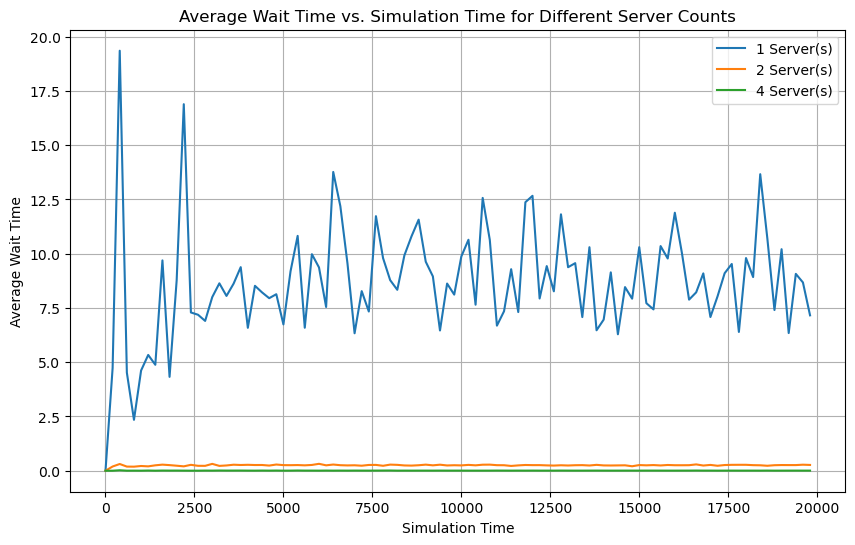

In [2]:
import simpy
import random
import statistics

# Parameters
λ = 0.9  # Arrival rate
μ = 1   # Service rate of each server
servers = [1, 2, 4]  # Number of servers to simulate
sim_time = 10000  # Simulation time

def customer(env, name, counter):
    """Customer process. Each customer arrives, waits, and is then served."""
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)
        service_time = random.expovariate(μ)
        yield env.timeout(service_time)

def setup(env, n):
    """Sets up the simulation environment with n servers."""
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(λ))
        env.process(customer(env, f'Customer{env.now}', counter))

average_wait_times = {n: [] for n in servers}  # Average waiting times for each number of servers
time_intervals = list(range(1, 20001, 200))  # Simulation time intervals from 1 to 20000, with a step of 200

for n in servers:
    random.seed(42)  # For reproducible results
    for sim_time in time_intervals:
        wait_times = []
        env = simpy.Environment()
        env.process(setup(env, n))
        env.run(until=sim_time)
        if wait_times:
            average_wait = statistics.mean(wait_times)
        else:
            average_wait = 0  # Set average wait to 0 if no data is available
        average_wait_times[n].append(average_wait)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for n in servers:
    plt.plot(time_intervals, average_wait_times[n], label=f'{n} Server(s)')

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts')
plt.legend()
plt.grid(True)
plt.show()

The statistical significance can be increased by running the simulation for a longer time or by executing multiple runs and averaging the results.
As for how the number of measurements required depends on ρ: When ρ is close to 1 (high system load), more measurements are needed to achieve high statistical significance due to increased variability in the system. Conversely, when ρ is lower, fewer measurements might suffice.

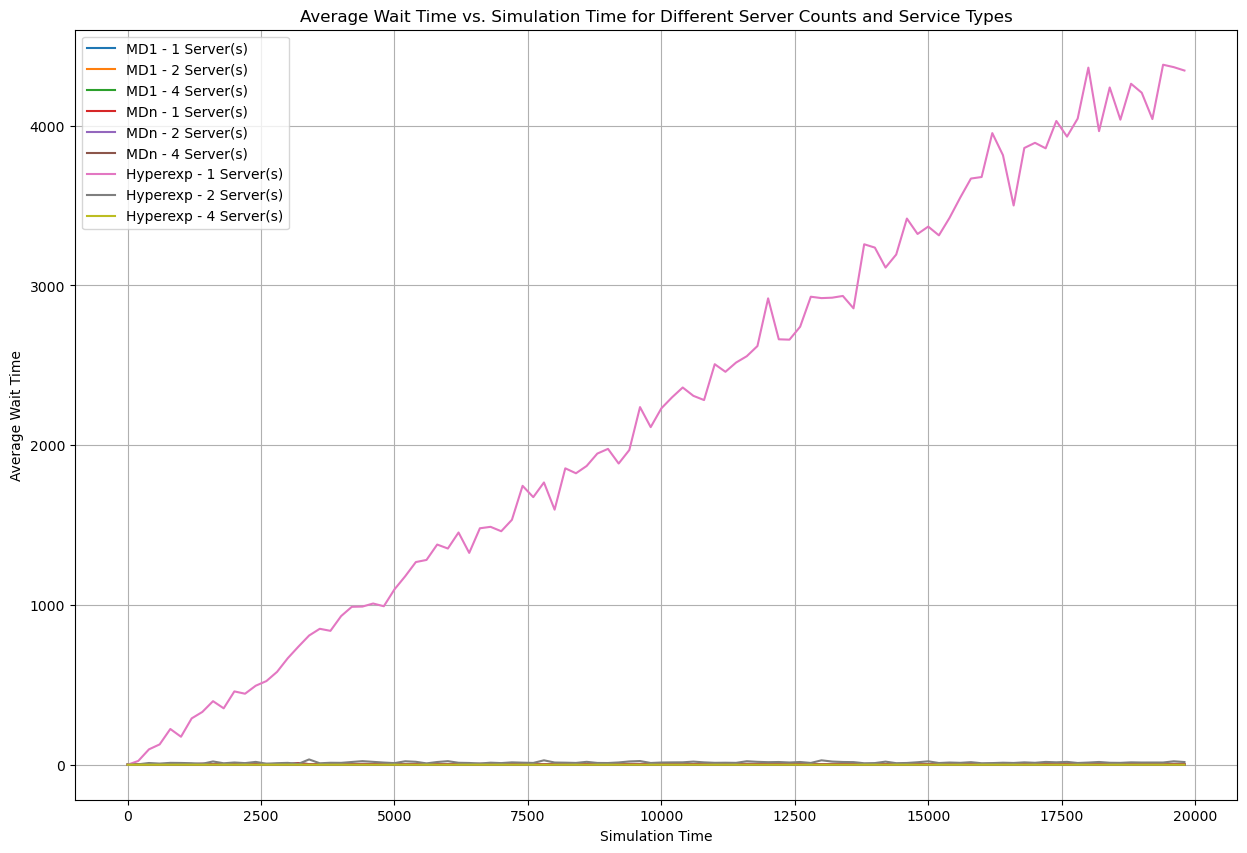

In [5]:
def multi_customer(env, name, counter, service_type):
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)

        if service_type == "MD1" or service_type == "MDn":
            # Deterministic service time
            service_time = 1 / μ
        elif service_type == "Hyperexp":
            # Hyperexponential service time
            if random.random() < 0.75:
                service_time = random.expovariate(1/1.0)  # 75% chance
            else:
                service_time = random.expovariate(1/5.0)  # 25% chance

        yield env.timeout(service_time)

def multi_setup(env, n, service_type):
    """Sets up the simulation environment with n servers and specified service type."""
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(λ))
        env.process(multi_customer(env, f'multi_customer{env.now}', counter, service_type))

λ = 0.9  # Arrival rate
μ = 1   # Service rate of each server
servers = [1, 2, 4]  # Number of servers to simulate
sim_time = 10000  # Simulation time

service_types = ["MD1", "MDn", "Hyperexp"]
time_intervals = list(range(1, 20001, 200))  # Simulation time intervals from 1 to 20000, with a step of 200

# Dictionary to hold average wait times for different service types and server counts
average_wait_times = {
    "MD1": {n: [] for n in servers},
    "MDn": {n: [] for n in servers},
    "Hyperexp": {n: [] for n in servers}
}

for service_type in service_types:
    for n in servers:

        # Reset random seed for reproducibility
        random.seed(42)
        for sim_time in time_intervals:
            wait_times = []
            env = simpy.Environment()
            env.process(multi_setup(env, n, service_type))
            env.run(until=sim_time)
            if wait_times:
                average_wait = statistics.mean(wait_times)
            else:
                average_wait = 0
            average_wait_times[service_type][n].append(average_wait)

plt.figure(figsize=(15, 10))

for service_type in service_types:
    for n in servers:
        plt.plot(time_intervals, average_wait_times[service_type][n], label=f'{service_type} - {n} Server(s)')

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts and Service Types')
plt.legend()
plt.grid(True)
plt.show()